In [1]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, ReLU
from keras.layers import BatchNormalization

import numpy as np
import os
import sys
from six.moves import cPickle
import matplotlib.pyplot as plt

import zipfile as zf
import os
import random
import shutil
from pathlib import Path
# get_transforms
from fastai.vision import *

Using TensorFlow backend.


In [3]:
files = zf.ZipFile("/content/gdrive/My Drive/data/dataset-resized.zip",'r')
files.extractall()
files.close()

os.listdir(os.path.join(os.getcwd(), 'dataset-resized'))

['.DS_Store', 'plastic', 'trash', 'paper', 'cardboard', 'metal', 'glass']

In [0]:
## helper functions ##

## splits indices for a folder into train and test indices with random sampling
    ## input: folder path
    ## output: train and test indices    
def split_indices(folder,seed1):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.75*n))

    ## separate remaining into test
    test = list(set(full_set)-set(train))
    
    return(train,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [0]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','test']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
# if not os.path.exists(os.path.join('data','test')):
    # os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, test_ind = split_indices(source_folder,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    test_dest = "data/test/"+waste_type
    move_files(test_source_files,test_dest)
    
    ## move source files to test
    # test_names = get_names(waste_type,test_ind)
    # test_source_files = [os.path.join(source_folder,name) for name in test_names]
    # ## I use data/test here because the images can be mixed up
    # move_files(test_source_files,"data/test")

In [8]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [0]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,valid="test",ds_tfms=tfms,bs=16)

In [27]:
data

ImageDataBunch;

Train: LabelList (1892 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
plastic,plastic,plastic,plastic,plastic
Path: /content/data;

Valid: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
plastic,plastic,plastic,plastic,plastic
Path: /content/data;

Test: None

In [28]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


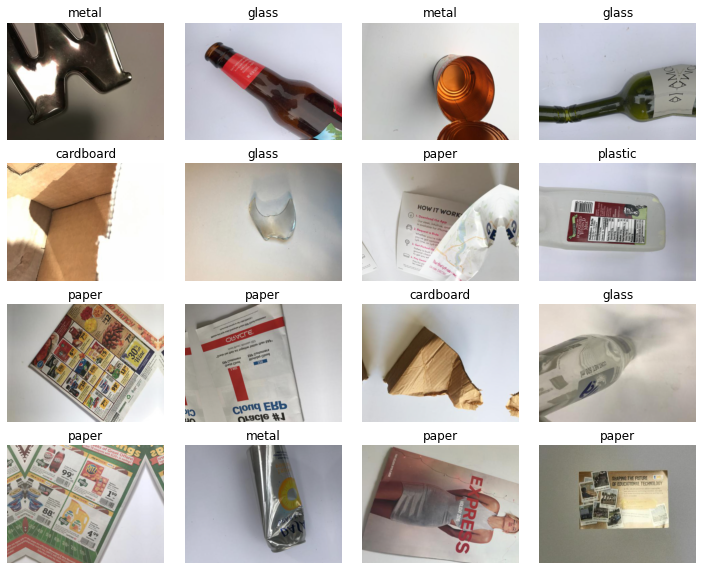

In [29]:
data.show_batch(rows=4,figsize=(10,8))

여기서부터 tensorflow 홈페이지에서 제공되는 dot, cat 분류 코드에서 가져온것.

In [32]:
train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')

print(train_dir)
print(test_dir)

/content/data/train
/content/data/test


In [0]:
train_cardboard_dir = os.path.join(train_dir, 'cardboard') 
train_glass_dir = os.path.join(train_dir, 'glass')
train_metal_dir = os.path.join(train_dir, 'metal')
train_paper_dir = os.path.join(train_dir, 'paper')
train_plastic_dir = os.path.join(train_dir, 'plastic')
train_trash_dir = os.path.join(train_dir, 'trash')


test_cardboard_dir = os.path.join(test_dir, 'cardboard') 
test_glass_dir = os.path.join(test_dir, 'glass')
test_metal_dir = os.path.join(test_dir, 'metal')
test_paper_dir = os.path.join(test_dir, 'paper')
test_plastic_dir = os.path.join(test_dir, 'plastic')
test_trash_dir = os.path.join(test_dir, 'trash')

In [34]:
num_cardboard_tr = len(os.listdir(train_cardboard_dir))
num_glass_tr = len(os.listdir(train_glass_dir))
num_metal_tr = len(os.listdir(train_metal_dir))
num_paper_tr = len(os.listdir(train_paper_dir))
num_plastic_tr = len(os.listdir(train_plastic_dir))
num_trash_tr = len(os.listdir(train_trash_dir))


num_cardboard_test = len(os.listdir(test_cardboard_dir))
num_glass_test = len(os.listdir(test_glass_dir))
num_metal_test = len(os.listdir(test_metal_dir))
num_paper_test = len(os.listdir(test_paper_dir))
num_plastic_test = len(os.listdir(test_plastic_dir))
num_trash_test = len(os.listdir(test_trash_dir))


total_train = num_cardboard_tr + num_glass_tr + num_metal_tr + num_paper_tr + num_plastic_tr + num_trash_tr
total_test = num_cardboard_test + num_glass_test + num_metal_test + num_paper_test + num_plastic_test + num_trash_test

print('total training cardboard images:', num_cardboard_tr)
print('total training glass images:', num_glass_tr)
print('total training metal images:', num_metal_tr)
print('total training paper images:', num_paper_tr)
print('total training plastic images:', num_plastic_tr) 
print('total training trash images:', num_trash_tr)


print('total test cardboard images:', num_cardboard_test) 
print('total test glass images:', num_glass_test)
print('total test metal images:', num_metal_test)
print('total test paper images:', num_paper_test)
print('total test plasticages images:', num_plastic_test)
print('total v trash images:', num_trash_test)
print("--")
print("Total training images:", total_train)
print("Total test images:", total_test)

total training cardboard images: 302
total training glass images: 375
total training metal images: 307
total training paper images: 445
total training plastic images: 361
total training trash images: 102
total test cardboard images: 101
total test glass images: 126
total test metal images: 103
total test paper images: 149
total test plasticages images: 121
total v trash images: 35
--
Total training images: 1892
Total test images: 635


In [0]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 384
IMG_WIDTH = 512

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our test data

In [69]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

Found 1892 images belonging to 6 classes.


In [70]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode = 'categorical')

Found 635 images belonging to 6 classes.


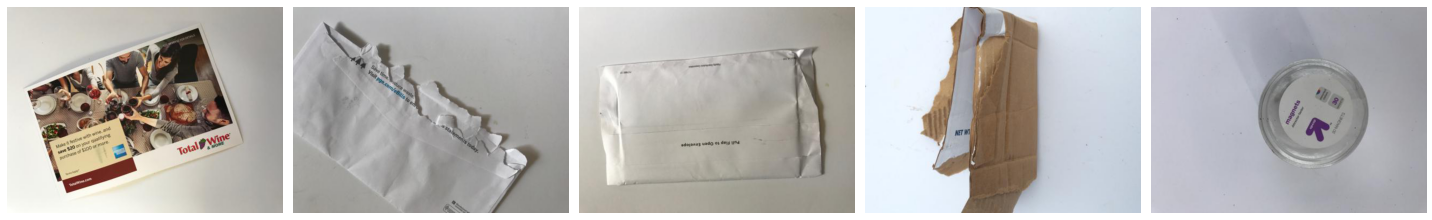

In [40]:
sample_training_images, _ = next(train_data_gen)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])

In [0]:
from tensorflow.keras.layers import  Flatten

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(6)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [71]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=total_test // batch_size
)

Epoch 1/15
14/14 [==============================] - 16s 1s/step - loss: 0.2643 - accuracy: 0.9263 - val_loss: 1.9254 - val_accuracy: 0.5645
Epoch 2/15
14/14 [==============================] - 16s 1s/step - loss: 0.1139 - accuracy: 0.9700 - val_loss: 2.1715 - val_accuracy: 0.5566
Epoch 3/15
14/14 [==============================] - 16s 1s/step - loss: 0.0756 - accuracy: 0.9853 - val_loss: 2.2204 - val_accuracy: 0.5879
Epoch 4/15
14/14 [==============================] - 16s 1s/step - loss: 0.0642 - accuracy: 0.9864 - val_loss: 2.5112 - val_accuracy: 0.5781
Epoch 5/15
14/14 [==============================] - 16s 1s/step - loss: 0.0582 - accuracy: 0.9877 - val_loss: 2.3511 - val_accuracy: 0.5879
Epoch 6/15
14/14 [==============================] - 16s 1s/step - loss: 0.0371 - accuracy: 0.9909 - val_loss: 2.6063 - val_accuracy: 0.5938
Epoch 7/15
14/14 [==============================] - 16s 1s/step - loss: 0.0392 - accuracy: 0.9927 - val_loss: 2.6176 - val_accuracy: 0.5684
Epoch 8/15
14/14 [==

In [0]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [55]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='categorical')

Found 1892 images belonging to 6 classes.


In [56]:
image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
                                                 directory=test_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='categorical')

Found 635 images belonging to 6 classes.


In [51]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(6)
])

model_new.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 384, 512, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 192, 256, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 192, 256, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 192, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 96, 128, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 96, 128, 64)       18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 64, 64)       

In [57]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=total_test // batch_size
)

Epoch 1/15
14/14 [==============================] - 83s 6s/step - loss: 1.6616 - accuracy: 0.2920 - val_loss: 2.0965 - val_accuracy: 0.2168
Epoch 2/15
14/14 [==============================] - 82s 6s/step - loss: 1.5491 - accuracy: 0.3798 - val_loss: 1.9045 - val_accuracy: 0.3105
Epoch 3/15
14/14 [==============================] - 82s 6s/step - loss: 1.4823 - accuracy: 0.3980 - val_loss: 1.4445 - val_accuracy: 0.3848
Epoch 4/15
14/14 [==============================] - 83s 6s/step - loss: 1.4673 - accuracy: 0.4025 - val_loss: 1.6620 - val_accuracy: 0.3887
Epoch 5/15
14/14 [==============================] - 82s 6s/step - loss: 1.3917 - accuracy: 0.4354 - val_loss: 1.8593 - val_accuracy: 0.3223
Epoch 6/15
14/14 [==============================] - 82s 6s/step - loss: 1.3771 - accuracy: 0.4609 - val_loss: 1.6914 - val_accuracy: 0.3926
Epoch 7/15
14/14 [==============================] - 82s 6s/step - loss: 1.2987 - accuracy: 0.4762 - val_loss: 1.4418 - val_accuracy: 0.4551
Epoch 8/15
14/14 [==